<a href="https://colab.research.google.com/github/bboszori/ds_assesment/blob/main/04_classification_homework_bboszori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification homework

## Evaluation Criteria (100% in total)
* EDA: exploration of variables and properties of data with conclusions (10%)
* Data preprocessing if needed (15% max)
  * Handling missing values
  * Dropping unimportant features
  * Data normalization
  * Categorical encoding
*Metrics and cross-validation have been chosen based on target distribution as well as reasoning behind (15%)
* Feature importance and hyperparameters tuning (10%)
* Models (20% max):
  * Logistic Regression w\wo regularization (10%)
  * K-nearest neighbours (10%)
* Quality of delivered work (20% max):
  * Analytical comments provided (10%)
  * The experiment is structured: file is readable, pictures have titles, etc (5%)
  * Code is clear: reusable code in functions, comments, code is easy readable, etc (5%)
* Extra points for improvements not considered in the criteria (10%)




In [ ]:
pip install pandas_profiling

In [ ]:
pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from statistics import mean
import statsmodels.api as sm
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, confusion_matrix, roc_curve
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.base import clone

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls '/content/gdrive/MyDrive/Data_Science_mentoring/05_classification_1'

classification_homework_bboszori.ipynb	dataset_57_hypothyroid.csv


In [ ]:
# Commonly used constants and paths
SEED = 42
DATA_PATH = '/content/gdrive/MyDrive/Data_Science_mentoring/05_classification_1'
DATA_FILE = f'{DATA_PATH}/dataset_57_hypothyroid.csv'
TARGET = 'Class'

In [ ]:
data = pd.read_csv(DATA_FILE)

## EDA: exploration of variables and properties of data with conclusions (10%)


In [ ]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

   TT4 T4U_measured   T4U FTI_measured  FTI TBG_measured TBG referral_source  \
0  125            t  1.14            t  109            f   ?            SVHC   
1  102            f     ?            f    ?            f   ?           other   
2  109            t  0.91            t  120            f   ?           other   
3  175            f     ?            f    ?            f   ?           other   
4   61            t  0.87            t   70            f   ?             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 30 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* Currently all numeric features are in string format
* ? is used for null values
* TBG feature only contains null values. TBG & TBG_measured can be dropped
*  There is 33 duplicate rows - need to be checked
* .*_measured fields are not contains relevant information
* Most of the features and the target variable are highly imbalanced -> mostly contains false

In [ ]:
for col in data.columns:
  data[col] = data[col].replace('?', np.nan)

In [ ]:
data.drop(list(data.filter(regex = '_measured')), axis = 1, inplace = True)
data.drop('TBG', axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3771 non-null   object
 1   sex                        3622 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Missing values
* sex has 150 (4.0%) missing values
* TSH has 369 (9.8%) missing values
* T3 has 769 (20.4%) missing values
* TT4 has 231 (6.1%) missing values
* T4U has 387 (10.3%) missing values
* FTI has 385 (10.2%) missing values

### High correlations
* Target variable has higher correlation with TSH (0.66), TT4(52) and FTI (0.56)
* T4U and pregnant is highly correlated: 0.6


In [ ]:
numerical_features = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'age']
categorical_features = ['referral_source']
boolean_features = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid','lithium','goitre','tumor','hypopituitary', 'psych']

In [ ]:
data[numerical_features] = data[numerical_features].astype(float)

In [ ]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41.0   F            f                  f                         f    f   
1  23.0   F            f                  f                         f    f   
2  46.0   M            f                  f                         f    f   
3  70.0   F            t                  f                         f    f   
4  70.0   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... tumor  \
0        f               f              f                 f  ...     f   
1        f               f              f                 f  ...     f   
2        f               f              f                 f  ...     f   
3        f               f              f                 f  ...     f   
4        f               f              f                 f  ...     f   

  hypopituitary psych   TSH   T3    TT4   T4U    FTI  referral_source  \
0             f     f  1.30  2.5  125.0  1.14  109.0             SVHC   
1             f     f  4.10  2.0  102.0   NaN    NaN            other   
2             f     f  0.98  NaN  109.0  0.91  120.0            other   
3             f     f  0.16  1.9  175.0   NaN    NaN            other   
4             f     f  0.72  1.2   61.0  0.87   70.0              SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 23 columns]

In [ ]:
data[(data['sex'].isna())&(data['pregnant']=='t')]

age  sex on_thyroxine query_on_thyroxine on_antithyroid_medication  \
1609  73.0  NaN            f                  f                         f   
3271  21.0  NaN            f                  f                         f   

     sick pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  \
1609    f        t               f              f                 f  ...   
3271    f        t               f              f                 f  ...   

     tumor hypopituitary psych  TSH   T3    TT4   T4U    FTI  referral_source  \
1609     f             f     f  2.2  2.5  110.0  1.28   85.0            other   
3271     t             f     f  2.4  3.5  171.0  1.49  115.0             STMW   

         Class  
1609  negative  
3271  negative  

[2 rows x 23 columns]

In [ ]:
# filling in sex with 'F', when patient is pregnant
data[(data['sex'].isna())&(data['pregnant']=='t')]['sex'] = 'F'

In [ ]:
data.sex.value_counts()/data.sex.count()

F    0.684705
M    0.315295
Name: sex, dtype: float64

In [ ]:
data['sex'].fillna(pd.Series(np.random.choice(['F','M'], p=[0.68, 0.32], size=len(data))), inplace=True)

In [ ]:
# filling in null values with median, as most of numerical values are skewed
for col in numerical_features:
  data[col] = data[col].fillna(data[col].median())

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3772 non-null   float64
 1   sex                        3772 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [ ]:
data[TARGET].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
#dropping instances of secondary_hypothyroid, as we only have 2 cases
data = data[data[TARGET]!='secondary_hypothyroid']

In [ ]:
# encode class values with LabelEncoder

labelenc = LabelEncoder()
data[TARGET] = labelenc.fit_transform(data[TARGET])

In [ ]:
data[TARGET].value_counts()

1    3481
0     194
2      95
Name: Class, dtype: int64

In [ ]:
#splitting data to train and test sets with 65:35 ratio
x_train, x_test, y_train, y_test = train_test_split(data.drop(TARGET,axis=1), data[TARGET], test_size=0.35, stratify=data[TARGET])

In [ ]:
# as referral_source is categorical feature, I use OneHotEncoder
df_train = pd.get_dummies(x_train[categorical_features])
x_train = pd.concat([x_train, df_train], axis=1)

df_test = pd.get_dummies(x_test[categorical_features])
x_test = pd.concat([x_test, df_test], axis=1)

In [ ]:
x_train.shape
x_test.shape

(2450, 27)

(1320, 27)

In [ ]:
x_train.drop('referral_source', axis=1, inplace=True)
x_test.drop('referral_source', axis=1, inplace=True)

In [ ]:
for col in boolean_features:
  x_train[col] = labelenc.fit_transform(x_train[col])
  x_test[col] = labelenc.fit_transform(x_test[col])

In [ ]:
x_train.head()

age  sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
1294  25.0    0             0                   0                          0   
2475  15.0    0             0                   0                          0   
666   47.0    0             0                   0                          0   
983   59.0    1             0                   0                          0   
3608  61.0    0             1                   0                          0   

      sick  pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
1294     0         0                0               0                  0  ...   
2475     0         0                0               0                  0  ...   
666      0         0                0               0                  0  ...   
983      0         0                0               0                  0  ...   
3608     0         0                0               0                  1  ...   

        TSH   T3    TT4   T4U    FTI  referral_source_STMW  \
1294   0.70  1.6   94.0  0.93  101.0                     0   
2475   1.60  2.4  105.0  1.16   91.0                     0   
666   11.00  2.6   91.0  0.98  107.0                     0   
983    4.90  1.4   96.0  0.88  109.0                     0   
3608   0.41  1.2  116.0  0.87  134.0                     0   

      referral_source_SVHC  referral_source_SVHD  referral_source_SVI  \
1294                     0                     0                    1   
2475                     0                     0                    0   
666                      0                     0                    0   
983                      0                     0                    1   
3608                     0                     0                    1   

      referral_source_other  
1294                      0  
2475                      1  
666                       1  
983                       0  
3608                      0  

[5 rows x 26 columns]

In [ ]:
minmax = MinMaxScaler()
x_train = pd.DataFrame(minmax.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(minmax.transform(x_test), columns=x_test.columns)

In [ ]:
# As dataset is highly imbalanced, I am using SMOTE oversampling
oversample = SMOTE(sampling_strategy={1:3481, 0:2000, 2:2000})
x_train_os, y_train_os = oversample.fit_resample(x_train, y_train)

In [ ]:
def drawConfusionMAtrix(y, y_pred):
  cm = confusion_matrix(y, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual 0', 'Actual 1', 'Actual 2'],
                                 index=['Predict 0', 'Predict 1', 'Predict 2'])

  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')

In [ ]:
def evaluate_model(train_x, train_y, test_x, test_y, model):
  est = model.fit(train_x, train_y)
  scores = cross_val_score(estimator=model, X=train_x, y=train_y, cv=5)
  print(f"Cross-validated mean score:", mean(scores))
  print(f"Cross-validated scores:", scores)

  predictions = cross_val_predict(estimator=est, X=train_x, y=train_y, cv=5)
  test_score = est.score(test_x, test_y)
  test_pred = est.predict(test_x)
  test_pred_proba = est.predict_proba(test_x)
  print(f"Test_score: {test_score}")

  drawConfusionMAtrix(test_y, test_pred)

  metric_df = pd.DataFrame({
            'accuracy': [accuracy_score(test_y, test_pred)],
            'precision': [precision_score(test_y, test_pred, average='weighted')],
            'recall': [recall_score(test_y, test_pred, average='weighted')],
            'log_loss': [log_loss(test_y, test_pred_proba)],
            'roc_auc': [roc_auc_score(test_y, test_pred_proba, multi_class='ovr')]
  })

  return metric_df, train_x.columns

Cross-validated mean score: 0.8347802556985628
Cross-validated scores: [0.84368737 0.81550802 0.83622995 0.85294118 0.82553476]
Test_score: 0.8787878787878788


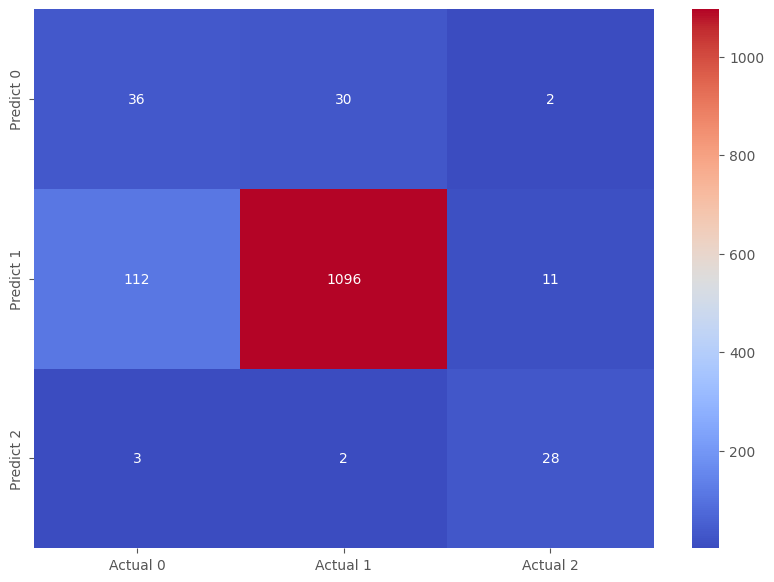

In [ ]:
# Baseline LogisticRegression model, using saga as solver to handle multiclass classification
logreg = LogisticRegression(solver='saga')
metrics, cols = evaluate_model(x_train_os, y_train_os, x_test, y_test, logreg)

In [ ]:
metrics

accuracy  precision    recall  log_loss   roc_auc
0  0.878788   0.926642  0.878788  0.390668  0.898772

In [ ]:
def plot_importance(est, colnames, class_nr, top_n=20):
  importance = pd.DataFrame({
      'abs_weight': np.abs(est.coef_[class_nr,:]),
      'feature': colnames
  })

  imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
  sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h').set(title=f'Class {class_nr}')

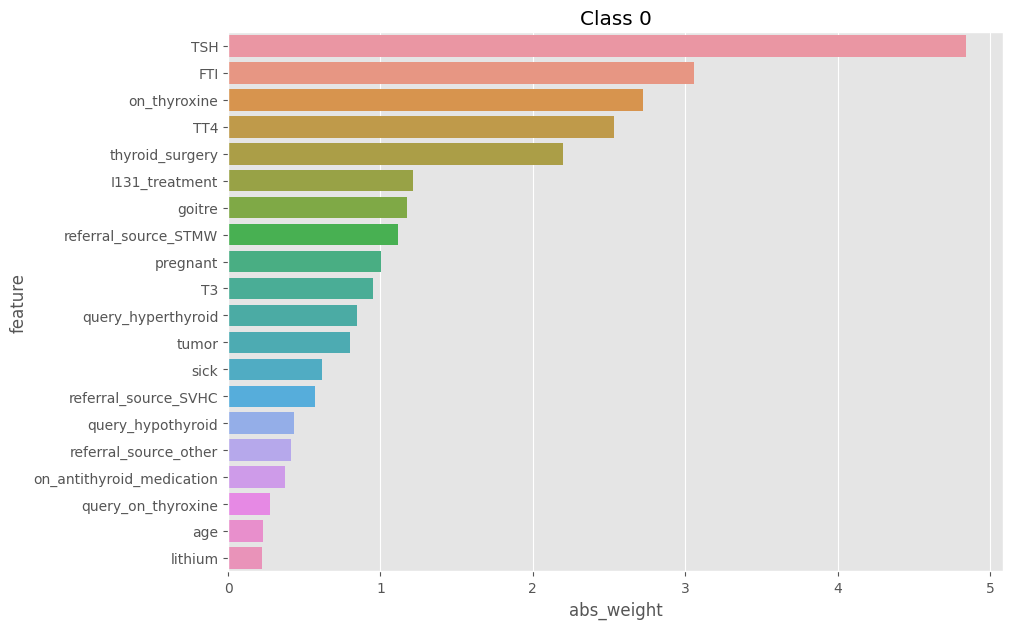

In [ ]:
plot_importance(logreg.fit(x_train_os, y_train_os),x_train_os.columns, 0)

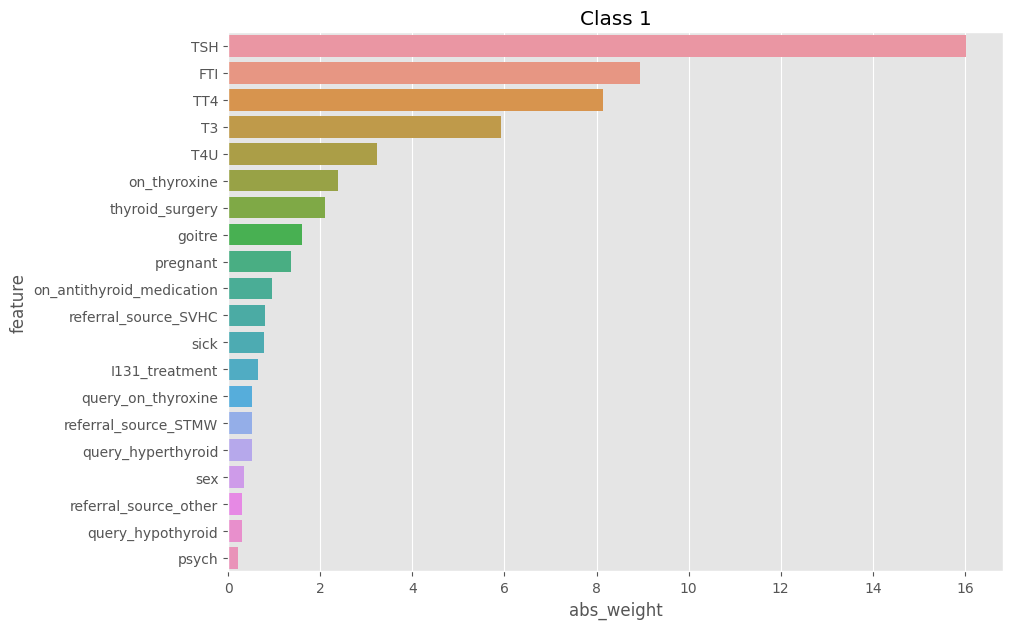

In [ ]:
plot_importance(logreg.fit(x_train_os, y_train_os),x_train_os.columns, 1)

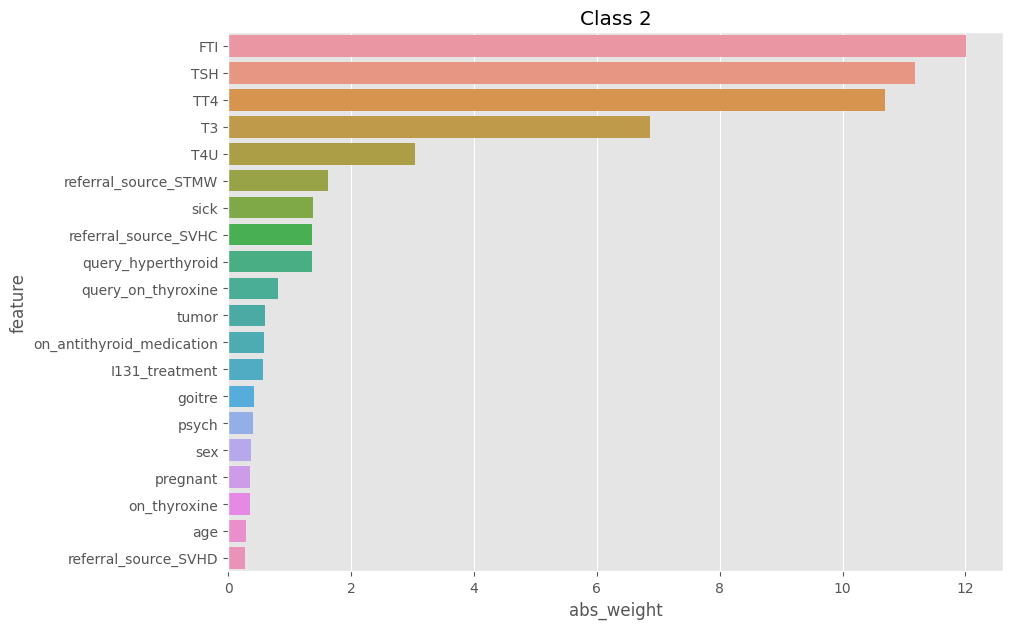

In [ ]:
plot_importance(logreg.fit(x_train_os, y_train_os),x_train_os.columns, 2)

For Class 0 and 1, TSH is the most important feature.
For Class 2, FTI is the most important feature.

Cross-validated mean score: 0.8347802556985628
Cross-validated scores: [0.84368737 0.81550802 0.83622995 0.85294118 0.82553476]
Test_score: 0.8787878787878788


accuracy  precision    recall  log_loss   roc_auc
0  0.878788   0.926642  0.878788  0.390678  0.898764

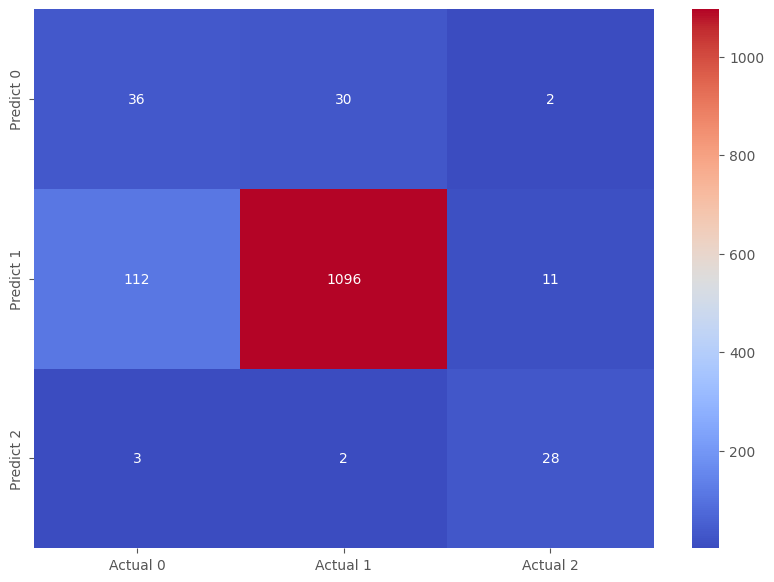

In [ ]:
logreg_l2 = LogisticRegression(solver='saga', penalty='l2')
metrics, cols = evaluate_model(x_train_os, y_train_os, x_test, y_test, logreg_l2)
metrics

Adding l2 penalty to the baseline model doesn't improve significantly the accuracy.

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(x_train_os,y_train_os)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1'}
accuracy : 0.9762075845094824


Cross-validated mean score: 0.9760738946699102
Cross-validated scores: [0.96726787 0.97058824 0.97459893 0.98328877 0.98462567]
Test_score: 0.9681818181818181


accuracy  precision    recall  log_loss   roc_auc
0  0.968182   0.970944  0.968182  0.194185  0.971837

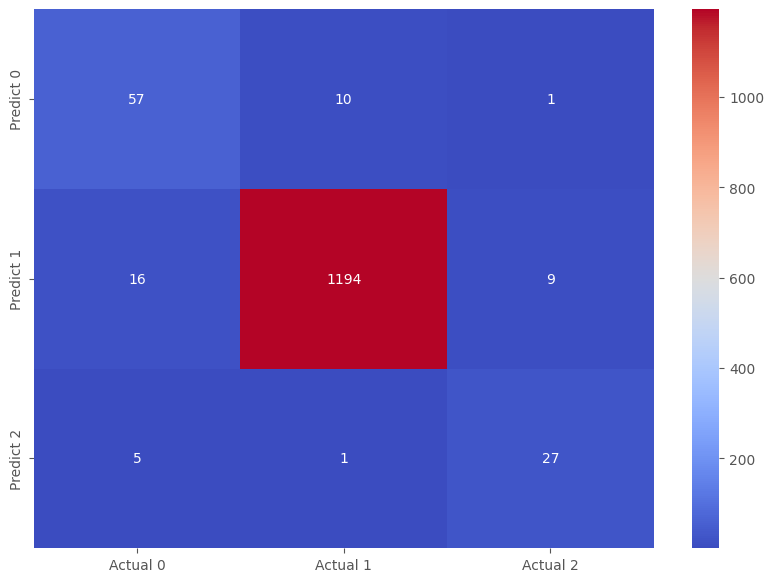

In [ ]:
logreg_best = LogisticRegression(solver='saga', penalty='l1', C=10.0)
metrics, cols = evaluate_model(x_train_os, y_train_os, x_test, y_test, logreg_best)
metrics

I Used GridsearchCV for hyperparametertuning.
The best parameters are C=10 and l1 penalty.
With these settings, the test score increased to ~0.96

In [ ]:
def checkKNN(X_train, y_train, X_test, y_test):
  neighbors = np.arange(1,10)
  train_accuracy =np.empty(len(neighbors))
  test_accuracy = np.empty(len(neighbors))

  for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    #Fit the model
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

  plt.title('k-NN Varying number of neighbors')
  plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
  plt.plot(neighbors, train_accuracy, label='Training accuracy')
  plt.legend()
  plt.xlabel('Number of neighbors')
  plt.ylabel('Accuracy')
  plt.show()

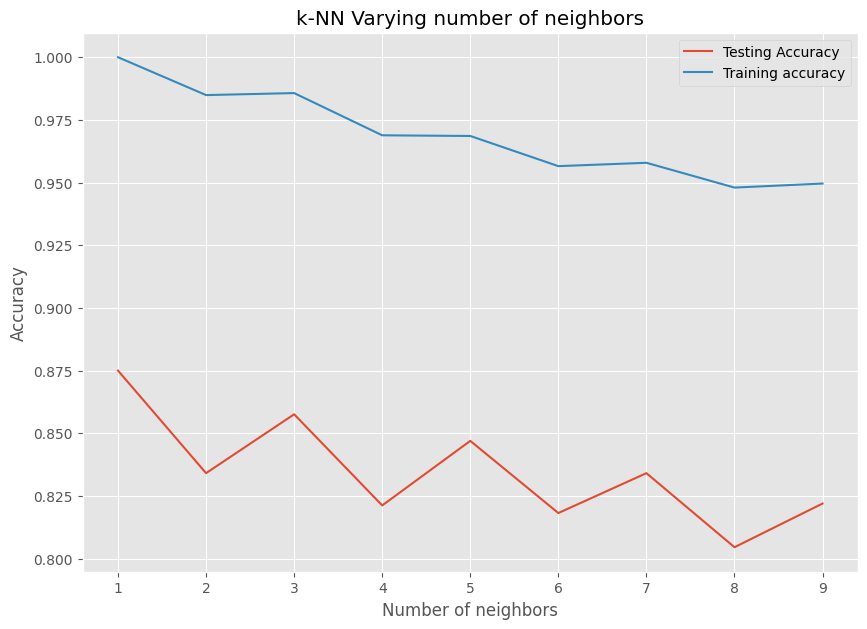

In [ ]:
checkKNN(x_train_os, y_train_os, x_test, y_test)

For KNN model, I checked the accuracy with different number of neighbors

Considering 1 neighbor gives the best results

Cross-validated mean score: 0.9746033957397862
Cross-validated scores: [0.96659987 0.96657754 0.96657754 0.98395722 0.98930481]
Test_score: 0.875


accuracy  precision  recall  log_loss   roc_auc
0     0.875   0.901319   0.875  4.505457  0.659082

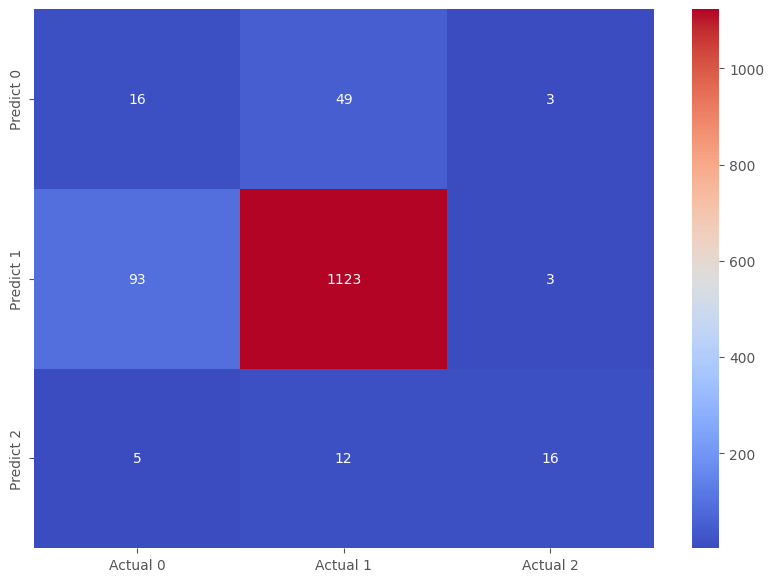

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
metrics, cols = evaluate_model(x_train_os, y_train_os, x_test, y_test, knn)
metrics

For KNN, we have a really good result on the train dataset.
But the score on test dataset is only 0.87